In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.ticker as ticker

In [3]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [2]:
# import npy files from results folder
# results_folder = 'results'
# data = np.load('data.npy')
am_qbc_runs = np.load('../results/AM_qbc_runs.npy')
am_qnipv_runs = np.load('../results/AM_qnipv_runs.npy')
am_random_runs = np.load('../results/AM_random_runs.npy')
am_unc_runs = np.load('../results/AM_uncertainty_runs.npy')

thermo_qbc_runs = np.load('../results/thermo_qbc_runs.npy')
thermo_qnipv_runs = np.load('../results/thermo_qnipv.npy')
thermo_uncertainty = np.load('../results/thermo_uncertainty.npy')
thermo_random = np.load('../results/thermo_random.npy')

nmr_uncr_runs = np.load('../results/nmr_uncr_runs.npy')
nmr_random_runs = np.load('../results/nmr_random_runs.npy')
nmr_qnipv_runs = np.load('../results/nmr_qnipv_runs.npy')
nmr_qbc_runs = np.load('../results/nmr_qbc_runs.npy')



### percent handler

In [3]:
def xpercent(total_candidates: int, initial_percent: int, num_iterations: int):
    # Calculate initial number of samples based on the initial percent
    initial_samples = int(initial_percent / 100 * total_candidates)
    x_percentages = [initial_percent]

    # Calculate percentages for each iteration
    for i in range(1, num_iterations + 1):
        percent = initial_percent + (i / total_candidates) * 100
        x_percentages.append(percent)
    return x_percentages

In [21]:
nmr_percent = xpercent(100, 5, 100)
thermo_percent = xpercent(163, 5, 155)
am_percent = xpercent(70, 5, 67)


In [109]:
len(am_percent)

68

In [72]:
nmr_qnipv_runs.min()

0.4837945587767183

### nmr runs

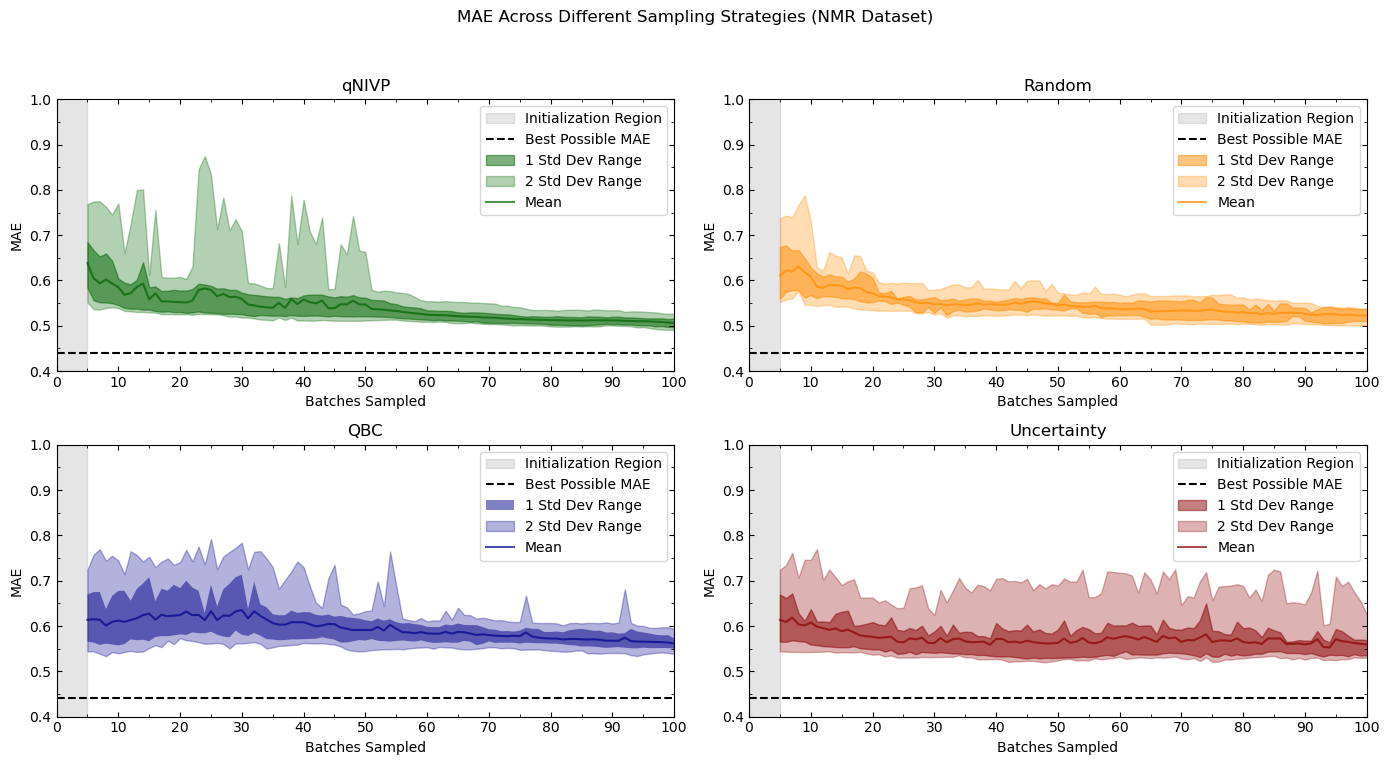

In [277]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies (NMR Dataset)')
    
for ax[0] in axs.flat:
    ax[0].axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    ax[0].axhline(y=0.44, color='k', linestyle='--', label='Best Possible MAE')
    # ax.axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
    # ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')
    ax[0].set_xlim([0, 100])
    ax[0].set_ylim([0.4, 1.0])
    ax[0].tick_params(axis='both', which='both', direction='in',top=True,right=True)
    ax[0].set_xticks(np.arange(0, 101, 10))
    ax[0].minorticks_on()
    ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[0].set_xlabel('Batches Sampled')


# First subplot: qNIVP
axs[0, 0].fill_between(nmr_percent, np.percentile(nmr_qnipv_runs,15.9,axis=0),np.percentile(nmr_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(nmr_percent,np.percentile(nmr_qnipv_runs,2.3,axis=0),np.percentile(nmr_qnipv_runs,97.7,axis=0), ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(nmr_percent, np.mean(nmr_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0, 0].set_title('qNIVP')
# axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(nmr_percent,np.percentile(nmr_random_runs,15.9,axis=0),np.percentile(nmr_random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(nmr_percent, np.percentile(nmr_random_runs,2.3,axis=0),np.percentile(nmr_random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(nmr_percent, np.mean(nmr_random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[0, 1].set_title('Random')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()



axs[1, 0].fill_between(nmr_percent, np.percentile(nmr_qbc_runs, 15.9,axis=0), np.percentile(nmr_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(nmr_percent, np.percentile(nmr_qbc_runs, 2.3, axis=0),np.percentile(nmr_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(nmr_percent, np.mean(nmr_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean')
axs[1, 0].set_title('QBC')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(nmr_percent, np.percentile(nmr_uncr_runs,15.9,axis=0), np.percentile(nmr_uncr_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(nmr_percent,np.percentile(nmr_uncr_runs,2.3,axis=0), np.percentile(nmr_uncr_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(nmr_percent, np.mean(nmr_uncr_runs,axis=0), color='darkred',alpha=0.7, label='Mean')
axs[1, 1].set_title('Uncertainty')
# axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()

### AutoAM Dataset

In [105]:
len(am_percent)

69

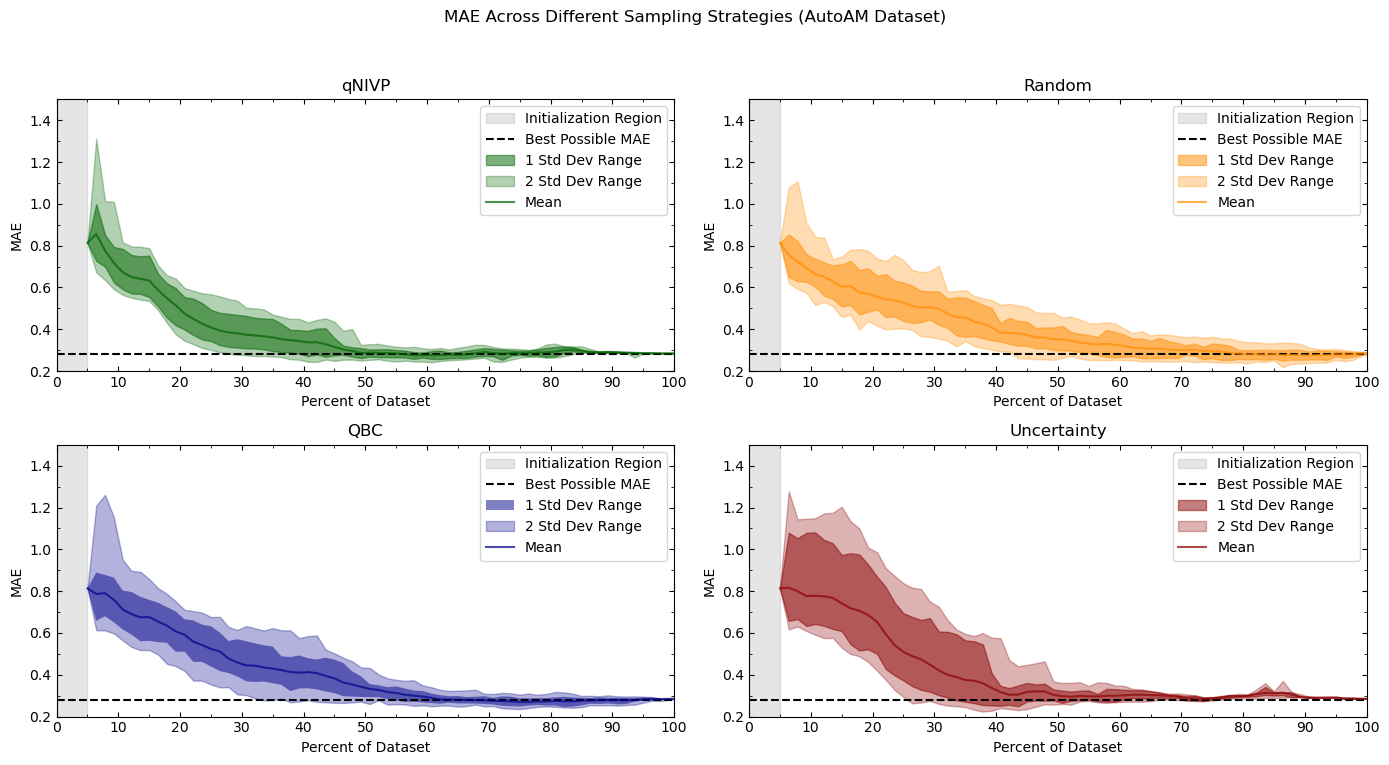

In [278]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies (AutoAM Dataset)')
    
for ax[0] in axs.flat:
    ax[0].axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    ax[0].axhline(y=0.28, color='k', linestyle='--', label='Best Possible MAE')
    # ax.axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
    # ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')
    ax[0].set_xlim([0, 100])
    ax[0].set_ylim([0.2, 1.5])
    ax[0].set_xticks(np.arange(0, 101, 10))
    ax[0].set_xlabel('Percent of Dataset')
    ax[0].tick_params(axis='both', which='both', direction='in',top=True,right=True)
    ax[0].minorticks_on()
    ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
    ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        
    


#increment the xticks by 10
for ax[0] in axs.flat:
    ax[0].set_xticks(np.arange(0, 101, 10))

# First subplot: qNIVP
axs[0, 0].fill_between(am_percent, np.percentile(am_qnipv_runs,15.9,axis=0),np.percentile(am_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(am_percent,np.percentile(am_qnipv_runs,2.3,axis=0),np.percentile(am_qnipv_runs,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(am_percent, np.mean(am_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0, 0].set_title('qNIVP')
# axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(am_percent,np.percentile(am_random_runs,15.9,axis=0),np.percentile(am_random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(am_percent, np.percentile(am_random_runs,2.3,axis=0),np.percentile(am_random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(am_percent, np.mean(am_random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[0, 1].set_title('Random')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()


# Third subplot: QBC
axs[1, 0].fill_between(am_percent, np.percentile(am_qbc_runs, 15.9,axis=0), np.percentile(am_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(am_percent, np.percentile(am_qbc_runs, 2.3, axis=0),np.percentile(am_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(am_percent, np.mean(am_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean')
axs[1, 0].set_title('QBC')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(am_percent, np.percentile(am_unc_runs,15.9,axis=0), np.percentile(am_unc_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(am_percent,np.percentile(am_unc_runs,2.3,axis=0), np.percentile(am_unc_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(am_percent, np.mean(am_unc_runs,axis=0), color='darkred',alpha=0.7, label='Mean')
axs[1, 1].set_title('Uncertainty')
# axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()

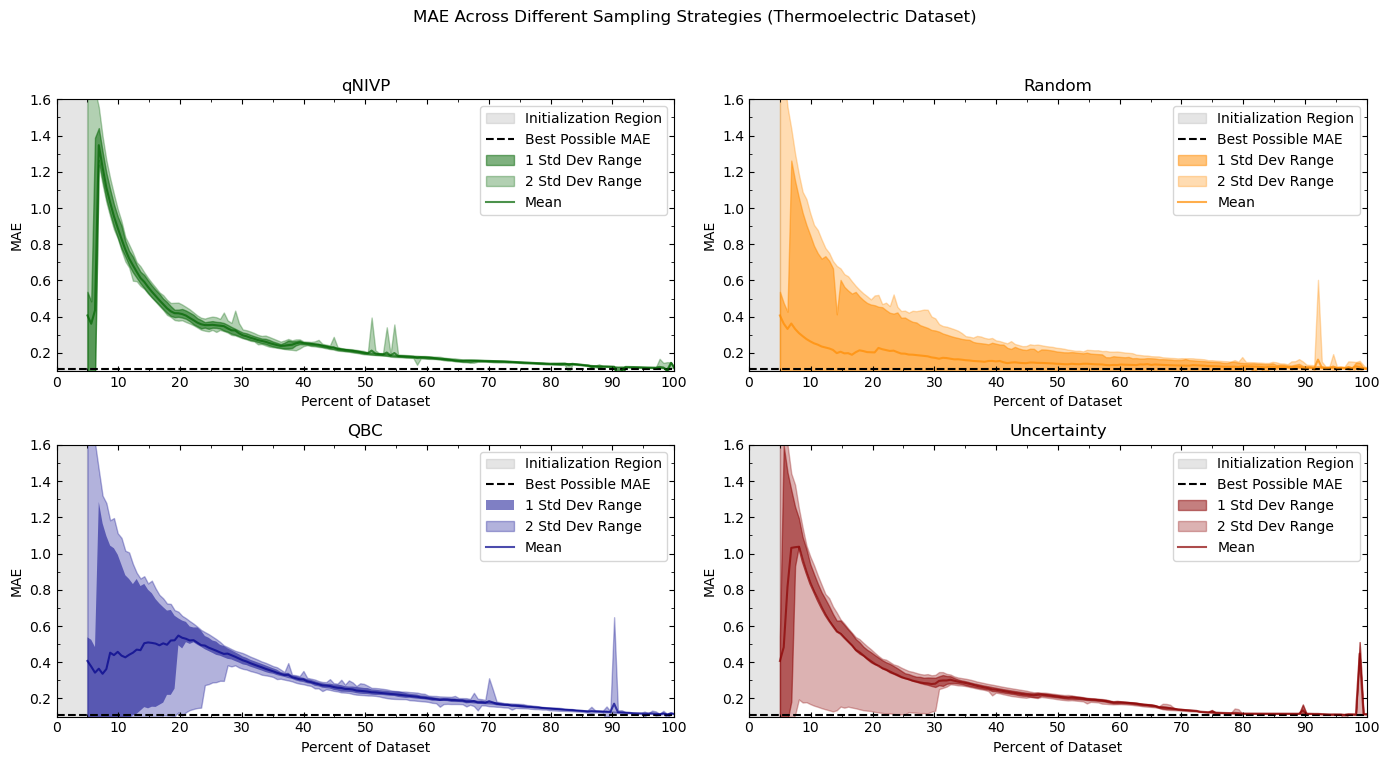

In [279]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies (Thermoelectric Dataset)')
    
for ax[0] in axs.flat:
    ax[0].axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    ax[0].axhline(y=0.11, color='k', linestyle='--', label='Best Possible MAE')
    # ax.axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
    # ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')
    ax[0].set_xlim([0, 100])
    ax[0].set_ylim([0.1, 1.6])
    ax[0].set_xticks(np.arange(0, 101, 10))
    ax[0].set_xlabel('Percent of Dataset')
    
    ax[0].tick_params(axis='both', which='both', direction='in',top=True,right=True)
    ax[0].minorticks_on()
    ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
    ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    
    


#increment the xticks by 10
for ax[0] in axs.flat:
    ax[0].set_xticks(np.arange(0, 101, 10))

# First subplot: qNIVP
axs[0, 0].fill_between(thermo_percent, np.percentile(thermo_qnipv_runs,15.9,axis=0),np.percentile(thermo_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(thermo_percent,np.percentile(thermo_qnipv_runs,2.3,axis=0),np.percentile(thermo_qnipv_runs,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(thermo_percent, np.mean(thermo_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0, 0].set_title('qNIVP')
# axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(thermo_percent,np.percentile(thermo_random,15.9,axis=0),np.percentile(thermo_random,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(thermo_percent, np.percentile(thermo_random,2.3,axis=0),np.percentile(thermo_random,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(thermo_percent, np.mean(thermo_random,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[0, 1].set_title('Random')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()


# Third subplot: QBC
axs[1, 0].fill_between(thermo_percent, np.percentile(thermo_qbc_runs, 15.9,axis=0), np.percentile(thermo_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(thermo_percent, np.percentile(thermo_qbc_runs, 2.3, axis=0),np.percentile(thermo_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(thermo_percent, np.mean(thermo_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean')
axs[1, 0].set_title('QBC')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(thermo_percent, np.percentile(thermo_uncertainty,15.9,axis=0), np.percentile(thermo_uncertainty,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(thermo_percent,np.percentile(thermo_uncertainty,2.3,axis=0), np.percentile(thermo_uncertainty,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(thermo_percent, np.mean(thermo_uncertainty,axis=0), color='darkred',alpha=0.7, label='Mean')
axs[1, 1].set_title('Uncertainty')
# axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()

In [118]:
logei_am = np.load('../results/logei_autoAM_qnipv_vs_logei_30percent.npy')
qnipv_am = np.load('../results/qnipv_autoAM_qnipv_vs_logei_30percent.npy')

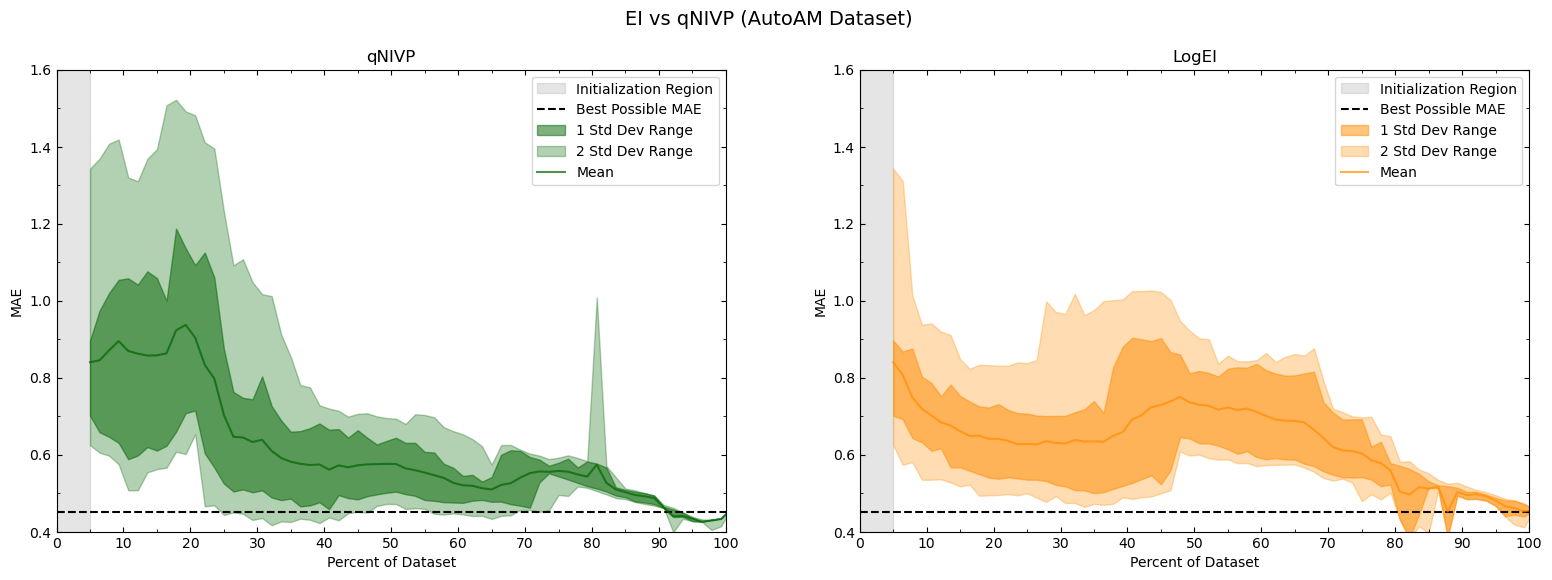

In [274]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(19, 6))
fig.suptitle('EI vs qNIVP (AutoAM Dataset)', size=14)

# Plot a horizontal line at y=0.28 for all subplots
# for ax in axs.flat:
#     ax.axhline(y=0.51, color='k', linestyle='--', label='Best MAE')
    
for ax[0] in axs.flat:
    # Highlight initialization region (0-5%)
    ax[0].axvspan(0, 5, color='gray', alpha=0.2,label='Initialization Region')
    # label='Initialization Region'
    # You can add more regions if needed:
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    
    ax[0].axhline(y=0.45, color='k', linestyle='--', label='Best Possible MAE')
    # label='Initialize w/ 5%'
    ax[0].set_xlim([0, 100])
    ax[0].set_ylim([0.4, 1.6])
    ax[0].set_xticks(np.arange(0, 101, 10))
    
    ax[0].tick_params(axis='both', which='both', direction='in',top=True,right=True)
    ax[0].minorticks_on()
    ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
    ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    


# First subplot: qNIVP
axs[0].fill_between(am_percent, np.percentile(qnipv_am,15.9,axis=0),np.percentile(qnipv_am,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
axs[0].fill_between(am_percent,np.percentile(qnipv_am,2.3,axis=0),np.percentile(qnipv_am,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0].plot(am_percent, np.mean(qnipv_am,axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0].set_title('qNIVP')
axs[0].set_xlabel('Percent of Dataset')
axs[0].set_ylabel('MAE')
axs[0].legend()

# Second subplot: EI
axs[1].fill_between(am_percent,np.percentile(logei_am,15.9,axis=0),np.percentile(logei_am,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[1].fill_between(am_percent, np.percentile(logei_am,2.3,axis=0),np.percentile(logei_am,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[1].plot(am_percent, np.mean(logei_am,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[1].set_title('LogEI')
axs[1].set_xlabel('Percent of Dataset')
axs[1].set_ylabel('MAE')
axs[1].legend()

### rate of change of MAE

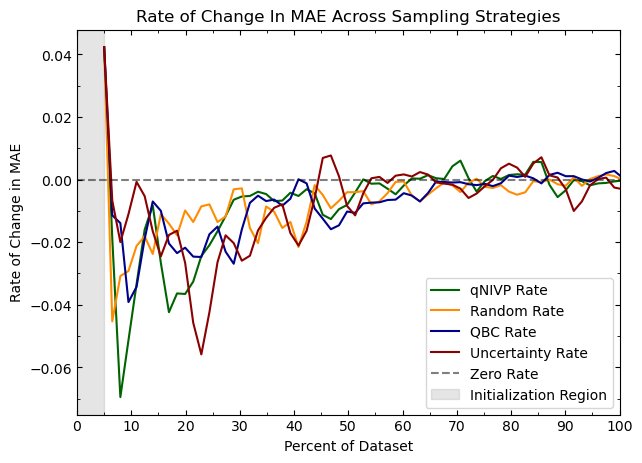

In [ ]:
# Compute gradients for each strategy
# nipv_rate = np.gradient(gaussian_filter1d(np.mean(am_qnipv_runs, axis=0), sigma=2), am_percent)
# random_rate = np.gradient(gaussian_filter1d(np.mean(am_random_runs, axis=0), sigma=2), am_percent)
# qbc_rate = np.gradient(gaussian_filter1d(np.mean(am_qbc_runs, axis=0), sigma=2), am_percent)
# uncertainty_rate = np.gradient(gaussian_filter1d(np.mean(am_unc_runs, axis=0),
# sigma=2), am_percent)

nipv_rate = np.gradient(np.mean(am_qnipv_runs,axis=0))
random_rate = np.gradient(np.mean(am_random_runs,axis=0))
qbc_rate = np.gradient(np.mean(am_qbc_runs,axis=0))
uncertainty_rate = np.gradient(np.mean(am_unc_runs,axis=0))


am_percent = np.linspace(0, 100, len(np.mean(am_qnipv_runs, axis=0)))

reference_value = nipv_rate[0]

random_offset = reference_value - random_rate[0]
qbc_offset = reference_value - qbc_rate[0]
uncertainty_offset = reference_value - uncertainty_rate[0]

# Apply the offsets only to the first point
random_rate[0] += random_offset
qbc_rate[0] += qbc_offset
uncertainty_rate[0] += uncertainty_offset

# Plot the adjusted gradients
fig, ax[0] = plt.subplots(figsize=(7, 5))
ax[0].plot(am_percent + 5 , nipv_rate, label="qNIVP Rate", color="darkgreen")
ax[0].plot(am_percent + 5, random_rate, label="Random Rate", color="darkorange")
ax[0].plot(am_percent + 5, qbc_rate, label="QBC Rate", color="darkblue")
ax[0].plot(am_percent + 5, uncertainty_rate, label="Uncertainty Rate", color="darkred")

# Highlight specific points (optional)
ax[0].axhline(0, color='k', linestyle='--', alpha=0.5, label="Zero Rate")
ax[0].axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
ax[0].set_xticks(np.arange(0, 101, 10))
ax[0].minorticks_on()
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[0].tick_params(which='both', axis='both', direction='in', top=True, right=True)

# Add labels, legend, and title
ax[0].set_xlabel("Percent of Dataset")
ax[0].set_ylabel("Rate of Change in MAE")
ax[0].set_title("Rate of Change In MAE Across Sampling Strategies")
ax[0].set_xlim([0, 100])
ax[0].legend()

plt.show()



### Plot of time for NMR dataset

In [4]:
timing_uncr_nmr = np.load('timing_uncertainty_nmr.npy').reshape(-1)
timing_qnipv_nmr = np.load('timing_qnipv_nmr.npy').reshape(-1)
timing_random_nmr = np.load('timing_random_nmr.npy').reshape(-1)
timing_qbc_nmr = np.load('timing_qbc_nmr.npy').reshape(-1)

In [5]:
iterations = np.linspace(0, 100, 100)
iterations.shape

(100,)

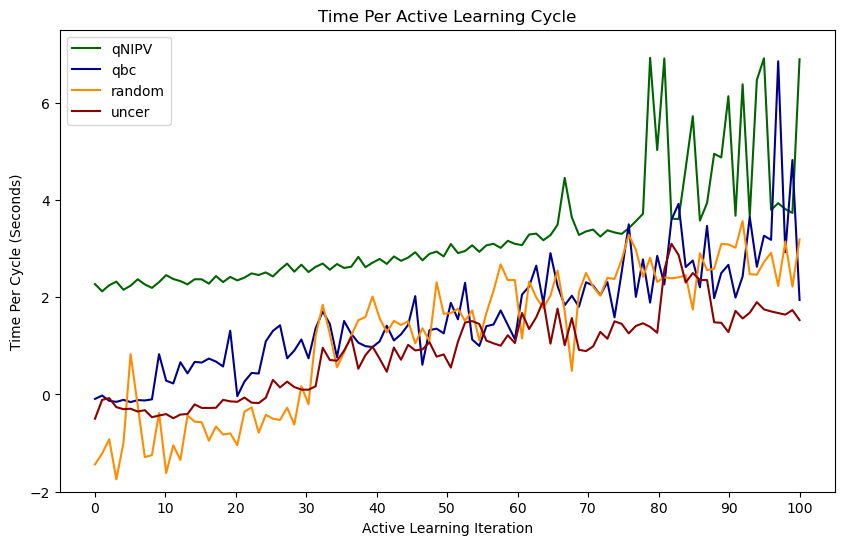

In [ ]:
fig, ax[0] = plt.subplots(figsize=(10, 6))

# plt.figure(figsize=(10, 6))
ax[0].plot(iterations, np.log(timing_qnipv_nmr), label="qNIPV",color="darkgreen")
ax[0].plot(iterations, np.log(timing_qbc_nmr), label="qbc", color='darkblue')
ax[0].plot(iterations, np.log(timing_random_nmr), label="random", color='darkorange')
ax[0].plot(iterations, np.log(timing_uncr_nmr), label="uncer",color='darkred')
ax[0].set_ylim([-2, 7.5])
ax[0].set_xticks(np.arange(0, 101, 10))
ax[0].set_xticks(np.arange(0, 101, 10))
ax[0].set_xlabel("Active Learning Iteration")
ax[0].set_ylabel("Time Per Cycle (Seconds)")
ax[0].set_title("Time Per Active Learning Cycle")
ax[0].legend()
# plt.grid(True)
plt.show()


### gaussian filter to smooth time curves

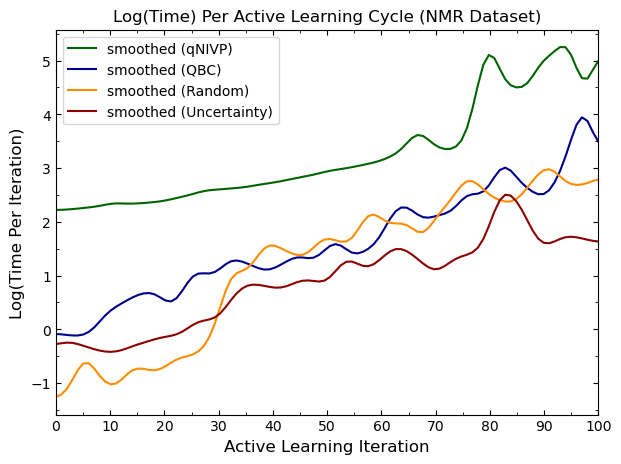

In [ ]:
import matplotlib.ticker as ticker

# Gaussian smoothing
smoothed_qnipv = gaussian_filter1d(np.log(timing_qnipv_nmr), sigma=2)
smoothed_qbc = gaussian_filter1d(np.log(timing_qbc_nmr), sigma=2)
smoothed_rand = gaussian_filter1d(np.log(timing_random_nmr), sigma=2)
smoothed_uncer = gaussian_filter1d(np.log(timing_uncr_nmr), sigma=2)

fig,ax[0], = plt.subplots(figsize=(7, 5))
ax[0].plot(iterations, smoothed_qnipv, label="smoothed (qNIVP)", color="darkgreen")
ax[0].plot(iterations, smoothed_qbc, label="smoothed (QBC)", color="darkblue")
ax[0].plot(iterations, smoothed_rand, label="smoothed (Random)", color="darkorange")
ax[0].plot(iterations, smoothed_uncer, label="smoothed (Uncertainty)", color="darkred")
# ax.plot(iterations, np.log(timing_qnipv_nmr), label="qNIVP", color="darkgreen")
# ax.plot(iterations, np.log(timing_qbc_nmr), label="QBC", color="darkblue")
# ax.plot(iterations, np.log(timing_random_nmr), label="Random", color="darkorange")
# ax.plot(iterations, np.log(timing_uncr_nmr), label="Uncertainty", color="darkred")
ax[0].set_xlabel("Active Learning Iteration",size=12)
ax[0].set_ylabel("Log(Time Per Iteration)",size=12)
ax[0].set_xlim([0, 100])
ax[0].tick_params(axis='both', which='both', direction='in',top=True,right=True)
ax[0].set_xticks(np.arange(0, 101, 10))
ax[0].minorticks_on()
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Minor ticks every half step
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[0].set_title("Log(Time) Per Active Learning Cycle (NMR Dataset)",size=12)

ax[0].legend()
plt.show()


/var/folders/qf/pmcgmztj4v91fy0j9fq_m9kc0000gn/T/ipykernel_12098/177979213.py:26: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,100,10)


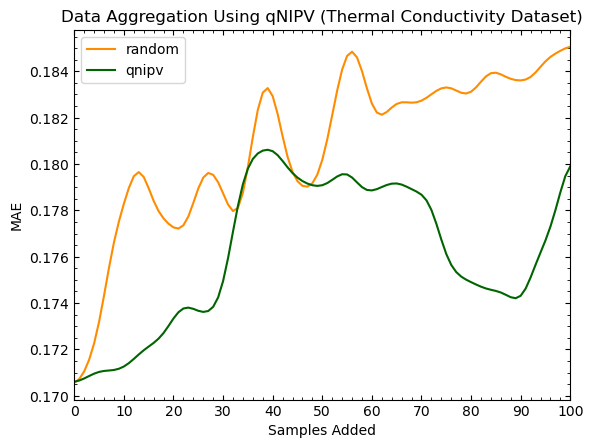

In [10]:
random_mae_np = np.load('data_agg_random_thermo_dataset.npy')
qnipv_dataagg = np.load('dataagg_thermo_qnipv.npy')
qnipv_np = qnipv_dataagg.reshape(-1)
qnipv_np

import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d
fig, ax[0] = plt.subplots()

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))

# ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.plot(np.linspace(0,100,101), gaussian_filter1d(random_mae_np,sigma=2), label='random', color='darkorange')
plt.plot(np.linspace(0,100,101), gaussian_filter1d(qnipv_np,sigma=2), label='qnipv', color='darkgreen')
# plt.axvline(0, color='gray', linestyle='--', label='Initialized w/ 70% Of Dataset')
plt.tick_params(axis='both', which='both', direction='in',top=True,right=True)
plt.minorticks_on()
#set minor ticks for both axis
# plt.xticks(np.arange(0, 101, 10))
# plt.yticks(np.arange(0.1, 1.6, 0.1))
plt.minorticks_on()
# plt.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Minor ticks every half step
# plt.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.xlim(0,100,10)
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Samples Added')
plt.ylabel('MAE')
plt.title('Data Aggregation Using qNIPV (Thermal Conductivity Dataset)')
plt.legend()

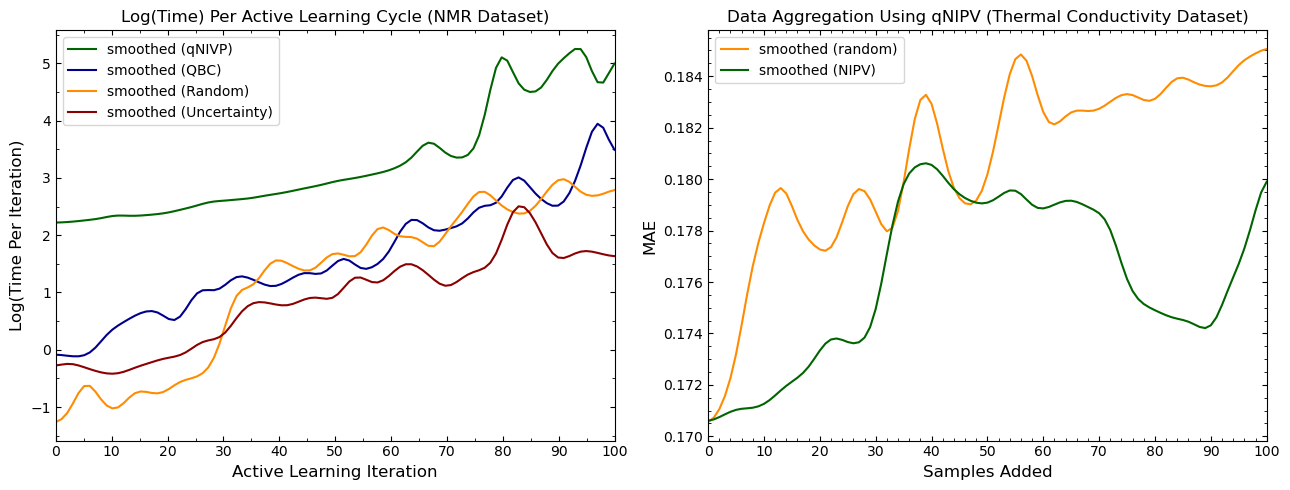

In [17]:


# random_mae_np = np.load('data_agg_random_thermo_dataset.npy')
# qnipv_dataagg = np.load('dataagg_thermo_qnipv.npy')
# qnipv_np = qnipv_dataagg.reshape(-1)
# qnipv_np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.ticker as ticker
import numpy as np

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# First subplot - Log Time
smoothed_qnipv = gaussian_filter1d(np.log(timing_qnipv_nmr), sigma=2)
smoothed_qbc = gaussian_filter1d(np.log(timing_qbc_nmr), sigma=2)
smoothed_rand = gaussian_filter1d(np.log(timing_random_nmr), sigma=2)
smoothed_uncer = gaussian_filter1d(np.log(timing_uncr_nmr), sigma=2)

ax1.plot(iterations, smoothed_qnipv, label="smoothed (qNIVP)", color="darkgreen")
ax1.plot(iterations, smoothed_qbc, label="smoothed (QBC)", color="darkblue")
ax1.plot(iterations, smoothed_rand, label="smoothed (Random)", color="darkorange")
ax1.plot(iterations, smoothed_uncer, label="smoothed (Uncertainty)", color="darkred")
ax1.set_xlabel("Active Learning Iteration", size=12)
ax1.set_ylabel("Log(Time Per Iteration)", size=12)
ax1.set_xlim([0, 100])
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax1.set_xticks(np.arange(0, 101, 10))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.set_title("Log(Time) Per Active Learning Cycle (NMR Dataset)", size=12)
ax1.legend()

# Second subplot - MAE
ax2.plot(np.linspace(0,100,101), gaussian_filter1d(random_mae_np, sigma=2), 
         label='smoothed (random)', color='darkorange')
ax2.plot(np.linspace(0,100,101), gaussian_filter1d(qnipv_np, sigma=2), 
         label='smoothed (NIPV)', color='darkgreen')
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.minorticks_on()
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_xlabel('Samples Added', size=12)
ax2.set_ylabel('MAE', size=12)
ax2.set_title('Data Aggregation Using qNIPV (Thermal Conductivity Dataset)')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'y')

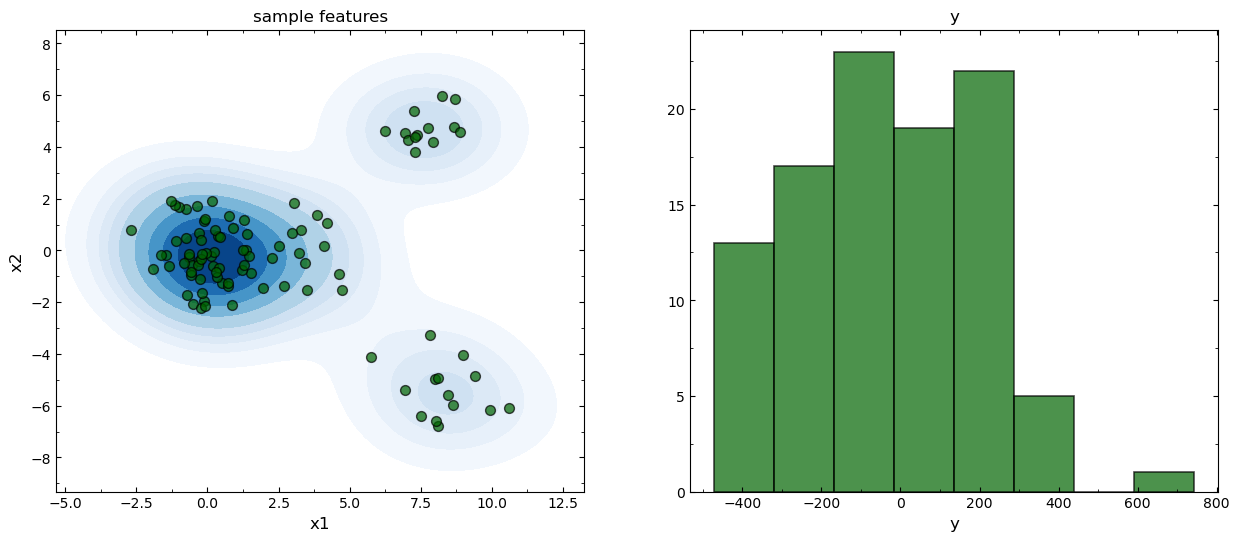

In [57]:
import numpy as np
import random
from sklearn.datasets import make_blobs, make_regression
import seaborn as sns
from scipy.stats import gaussian_kde
random.seed(42)
# x1,y1 = make_blobs(n_samples=25, centers=2, n_features=2, random_state=1)

# fig, ax = plt.subplots()
# ax.scatter(x1[:,0], x1[:,1], c=y1)
# y1

x1, y1 = make_regression(n_samples=60, n_features=2, noise=200, random_state=150)
xblob, yblob = make_blobs(n_samples=40, centers=3, n_features=2, random_state=150, cluster_std=0.9)

samples = np.random.normal(y1.mean(), y1.std(), 40)

x1 = np.concatenate((x1, xblob), axis=0)
y1 = np.concatenate((y1, samples), axis=0)

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15, 6))

x1_min, x1_max = x1[:,0].min(), x1[:,0].max()
x2_min, x2_max = x1[:,1].min(), x1[:,1].max()

padding_factor = 0.2  
x1_range = x1_max - x1_min
x2_range = x2_max - x2_min

ax1.set_xlim(x1_min - padding_factor * x1_range, x1_max + padding_factor * x1_range)
ax1.set_ylim(x2_min - padding_factor * x2_range, x2_max + padding_factor * x2_range)

sns.kdeplot(x=x1[:,0], y=x1[:,1], cmap='Blues', fill=True, ax=ax1)

# Plot scatter points on top
ax1.scatter(x1[:,0], x1[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1.0,alpha=0.7)
ax1.set_xlabel("x1", size=12)
ax1.set_ylabel("x2", size=12)
# ax.set_xlim([-7, 7])
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
# ax.set_xticks(np.arange(0, 7, 25))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.set_title("sample features", size=12)
# ax1.legend()




# y_max_hist = max(abs(y1.min()), abs(y1.max()))
# ax2.set_xlim(-10 + -y_max_hist, 10 + y_max_hist)
ax2.hist(y1, bins='auto', color="darkgreen", edgecolor='black', linewidth=1.2, alpha=0.7)
ax2.set_xlabel("y", size=12)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.set_title("y", size=12)
# ax2.legend()



In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models.gp_regression import SingleTaskGP
from tqdm import tqdm
from torch import Tensor
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)

from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
from botorch.models.gp_regression import SingleTaskGP

from sklearn.metrics import mean_absolute_error
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

# from botorch.models.transforms.input import Normalize
# from botorch.models.transforms.outcome import Standardize
import os 

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import warnings
import random
import torch
import pandas as pd
# from botorch.models.transforms.input import Normalize, Standardize
from botorch.utils.transforms import normalize, standardize

# warnings.filterwarnings("ignore", category=botorch.exceptions.BotorchWarning)

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )
import warnings
warnings.filterwarnings("ignore")

In [59]:
xlower_bounds = x1.min(axis=0)
xupper_bounds = x1.max(axis=0)

xlower_bounds = torch.tensor(xlower_bounds, dtype=torch.double)
xupper_bounds = torch.tensor(xupper_bounds, dtype=torch.double)

xbounds = torch.stack([xlower_bounds, xupper_bounds])
xbounds

#convert array to tensor
x = torch.tensor(x1, dtype=torch.double)
y = torch.tensor(y1, dtype=torch.double)


x = normalize(x, bounds=xbounds)  
y = standardize(y)


In [60]:
x_candidates, x_test, y_candidates, y_test = train_test_split(x, y, test_size=0.30, random_state=300)

xtest = torch.tensor(x_test, dtype=torch.double)
ytest = torch.tensor(y_test, dtype=torch.double)

xcandidates_original = torch.tensor(x_candidates, dtype=torch.double)
ycandidates_original = torch.tensor(y_candidates, dtype=torch.double)

In [61]:
bnds = torch.tensor([[0,0], [1,1]], dtype=torch.double)
bounds = torch.tensor(bnds, dtype=torch.double)
bounds

tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)

In [62]:
from botorch.utils.sampling import draw_sobol_samples

mcp = draw_sobol_samples(bounds=bounds, n=1024, q=1, seed=300).squeeze(1)
mcp.shape

torch.Size([1024, 2])

In [63]:
def random_initial_data(x, y, initial_percent, seed):
    np.random.seed(seed)
    n = int(x.shape[0]*initial_percent)
    idx = np.random.choice(x.shape[0], n, replace=False)
    x_initial = x[idx]
    y_initial = y[idx]
    x_candidates = np.delete(x, idx, axis=0)
    y_candidates = np.delete(y, idx, axis=0)
    return x_initial, y_initial, x_candidates, y_candidates

In [64]:
xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

In [65]:
ycandidates = ycandidates.unsqueeze(-1)
ycandidates.shape

torch.Size([70, 1])

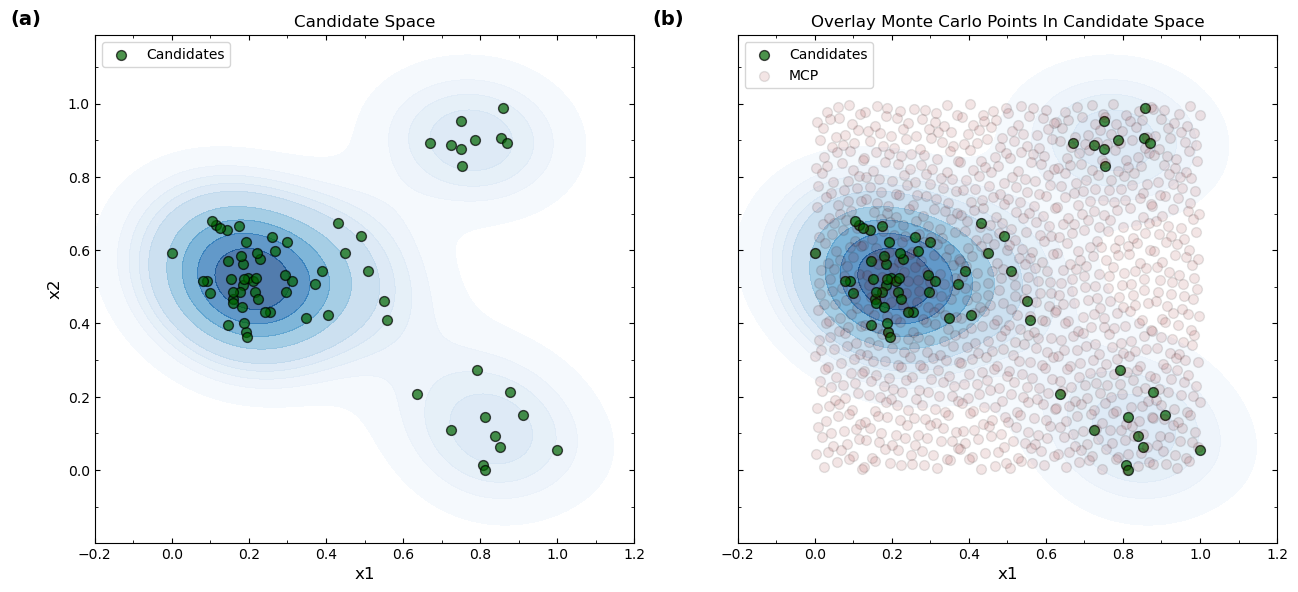

In [66]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13, 6),sharex=True,sharey=True)

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True, alpha=0.7)
ax[0].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.7)
# ax[0].scatter(xtest[:,0], xtest[:,1], c='yellow', s=50, edgecolor='k', linewidth=1, label='Test Set')
# ax.scatter(mcp[:,0], mcp[:,1], c='darkred', s=50, edgecolor='k', linewidth=1,alpha=0.1, label='MCP')
xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

padding_factor = 0.2
xcandidates_range1 = xcandidates_max1 - xcandidates_min1
xcandidates_range2 = ycandidates_max2 - xcandidates_min2

ax[0].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
ax[0].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
ax[0].set_label(' Samples')
ax[0].set_xlabel("x1", size=12)
ax[0].set_ylabel("x2", size=12)
ax[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax[0].minorticks_on()
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[0].set_title("Candidate Space", size=12)
#put the legend on the top left side
ax[0].legend(loc='upper left')
# ax.legend()
# mcp_hist = mcp.reshape(-1)
# mcp_hist
# kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
# ax[1].hist(ytest, histtype='stepfilled', alpha=0.3, density=True, bins=40, label='MCP')
# ax[1].hist(, histtype='stepfilled', alpha=0.3, density=True, bins=40, label='Candidates')
# ax[1].hist(xcandidates, **kwargs)
# ax[1].hist(xtest, **kwargs)



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
ax[1].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.7)
ax[1].scatter(mcp[:,0], mcp[:,1], c='darkred', s=50, edgecolor='k', linewidth=1,alpha=0.1, label='MCP')

# ax.scatter(xtest[:,0], xtest[:,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='Test')
xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

padding_factor = 0.2
xcandidates_range1 = xcandidates_max1 - xcandidates_min1
xcandidates_range2 = ycandidates_max2 - xcandidates_min2

ax[1].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
ax[1].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
ax[1].set_xlabel("x1", size=12)
ax[1].set_ylabel("x2", size=12)
ax[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax[1].minorticks_on()
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax[1].set_title("Overlay Monte Carlo Points In Candidate Space", size=12)
#put the legend on the top left side
ax[1].legend(loc='upper left')

ax[0].text(-0.1, 1.05, '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
ax[1].text(-0.1, 1.05, '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

In [67]:
gp = SingleTaskGP(xcandidates, ycandidates) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

#predict the y values for the test set
ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()
# pred_y.append(ypred_mean)

#calculate the mean absolute error and the standard deviation for the test set
ymae = mean_absolute_error(ytest, ypred_mean)
ymae

0.8120799973118724

In [68]:
rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []
qnipv_runs =[]
candidates_selected =[]
qnipv_vals = []
candidates_qnpiv = []

list_of_acq_vals = []
def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())
        
        # print(qNIVP_val)
        # all_qnivp_vals.append(qNIVP_val)
        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst, 


seeds = [300]

for i in tqdm(seeds):
    xcandidates = xcandidates_original.clone()
    ycandidates = ycandidates_original.clone()
    xinit, yinit, xcandidates, ycandidates = random_initial_data(xcandidates, ycandidates, 0.05, seed=i)
    yinit = yinit.unsqueeze(-1)
    ycandidates = ycandidates.unsqueeze(-1)
    
    gp = SingleTaskGP(xinit, yinit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    ystd = posterior.stddev.detach().numpy()
    
    ymae = mean_absolute_error(ytest, ypred)
    
    pred_mae = []
    pred_y.append(ypred)
    pred_std.append(ystd)
    pred_mae.append(ymae)

    for inner_i in tqdm(range(len(xcandidates))):
        if not len(xcandidates):
            break
        
        qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
        
        
        max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
        
        list_of_acq_vals.append(acq_val_lst)
        
        candidates_qnpiv.append(xcandidates)
        xmax_candidates.append(max_index)
        
        xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
        yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
        
        xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
        ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
        
        
        gp = SingleTaskGP(xinit, yinit) 
        # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        #predict the y values for the test set
        ypred = gp(xtest)
        ypred_mean = ypred.mean.detach().numpy()
        pred_y.append(ypred_mean)

        #calculate the mean absolute error and the standard deviation for the test set
        ymae = mean_absolute_error(ytest, ypred_mean)
        # print('mean absolute error: ', ymae)
        pred_mae.append(ymae)
        ystd = gp(xtest).stddev
        ystd = ystd.detach().numpy()
        pred_std.append(ystd)
    
    
    qnipv_vals
    candidates_qnpiv
    list_of_acq_vals
    xinit
    qnipv_runs.append(pred_mae)

100%|██████████| 1/1 [00:50<00:00, 50.53s/it]


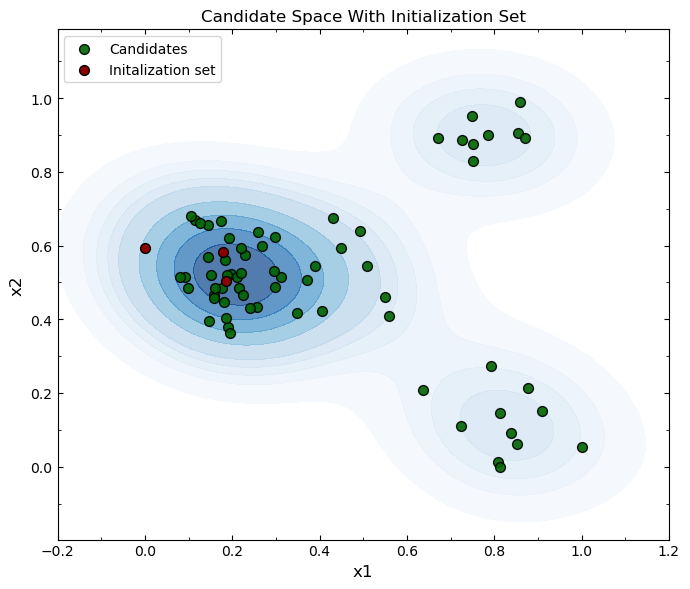

In [128]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7, 6),sharex=True,sharey=True)
sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax,legend=True,alpha=0.7)

ax.scatter(candidates_qnpiv[0][:,0], candidates_qnpiv[0][:,1], c="darkgreen",s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.9)
ax.scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initalization set')
ax.set_title("Candidate Space With Initialization Set", size=12)


xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

padding_factor = 0.2
xcandidates_range1 = xcandidates_max1 - xcandidates_min1
xcandidates_range2 = ycandidates_max2 - xcandidates_min2

ax.set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
ax.set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
ax.set_xlabel("x1", size=12)
ax.set_ylabel("x2", size=12)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

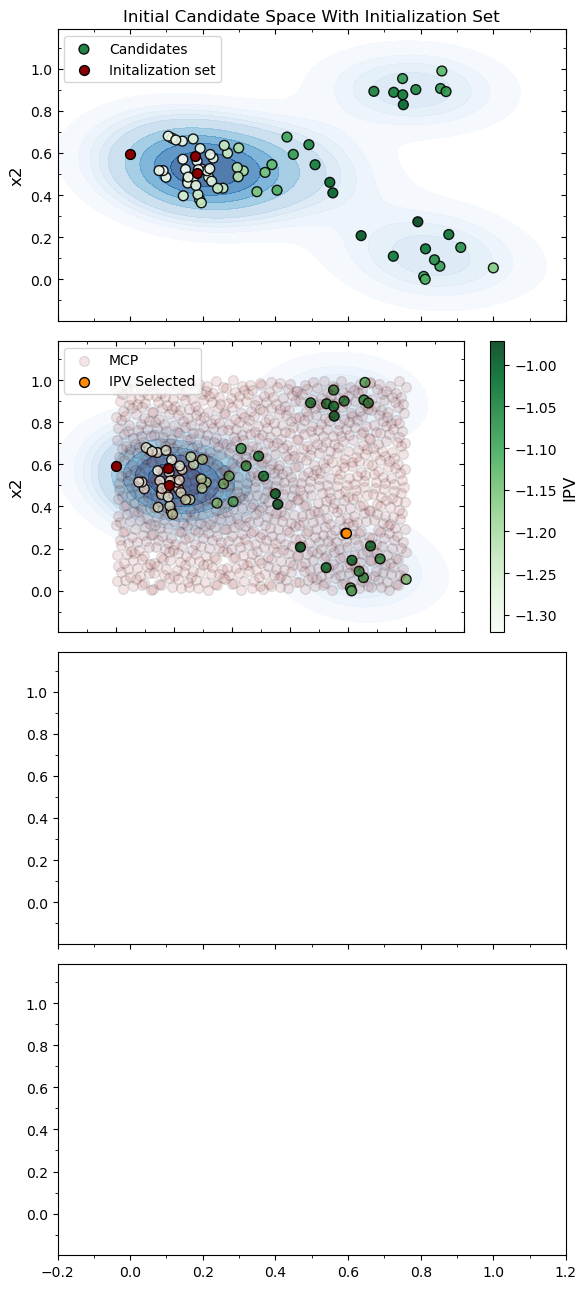

In [135]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(6, 13),sharex=True,sharey=True)


xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)

ax[0].scatter(candidates_qnpiv[0][:,0], candidates_qnpiv[0][:,1], c=list_of_acq_vals[0], cmap="Greens",s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.9)
ax[0].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initalization set')
ax[0].set_title("Initial Candidate Space With Initialization Set", size=12)


#-----


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)

cb = ax[1].scatter(candidates_qnpiv[0][:,0], candidates_qnpiv[0][:,1], c=list_of_acq_vals[0], cmap="Greens",s=50, edgecolor='k', linewidth=1,alpha=0.9)

cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("IPV", size=12)
# ax[1].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k',
# linewidth=1, label='initalization set')
ax[1].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1)
ax[1].scatter(mcp[:,0], mcp[:,1], c='darkred', s=50, edgecolor='k', linewidth=1,alpha=0.1, label='MCP')
ax[1].scatter(xinit[3:4,0], xinit[3:4,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='IPV Selected')

# ax[1].set_title("MCP Selected Candidate", size=12)




for i in range(len(ax[:2])):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=12)
    ax[i].set_ylabel("x2", size=12)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

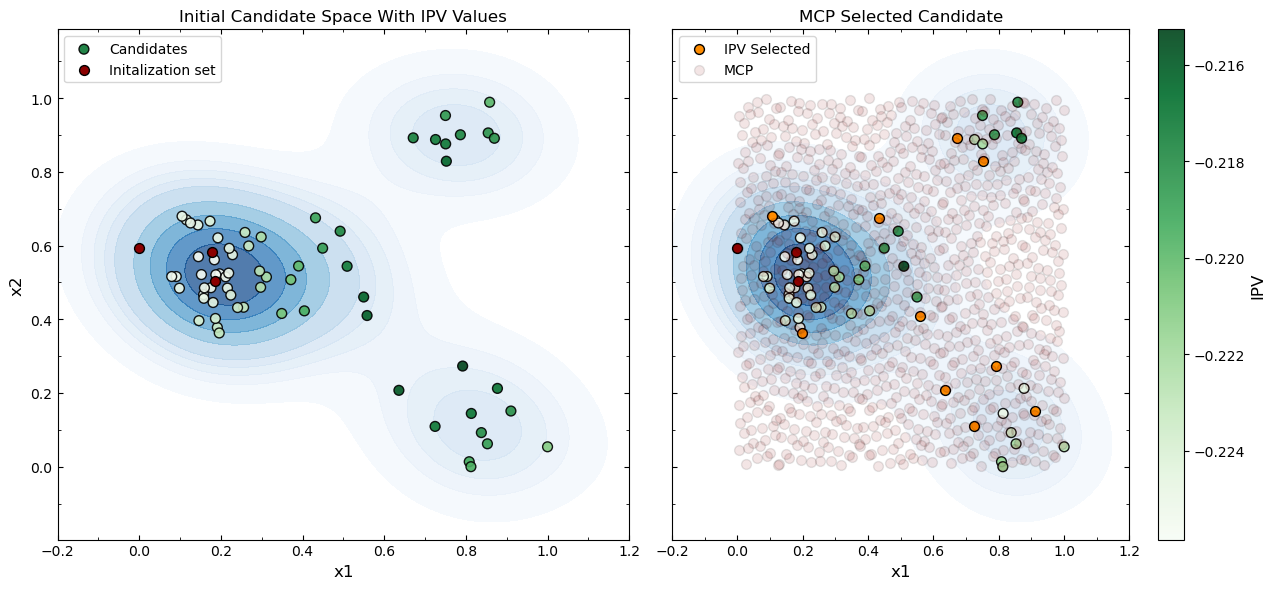

In [218]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13, 6),sharex=True,sharey=True)


xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)

ax[0].scatter(candidates_qnpiv[0][:,0], candidates_qnpiv[0][:,1], c=list_of_acq_vals[0], cmap="Greens",s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.9)
ax[0].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initalization set')
ax[0].set_title("Initial Candidate Space With IPV Values", size=12)


#-----


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)

cb = ax[1].scatter(candidates_qnpiv[10][:,0], candidates_qnpiv[10][:,1], c=list_of_acq_vals[10], cmap="Greens",s=50, edgecolor='k', linewidth=1,alpha=0.9)

cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("IPV", size=12)
# ax[1].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k',
# linewidth=1, label='initalization set')
ax[1].scatter(xinit[:3,0], xinit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1)
ax[1].scatter(xinit[3:13,0], xinit[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='IPV Selected')
ax[1].scatter(mcp[:,0], mcp[:,1], c='darkred', s=50, edgecolor='k', linewidth=1,alpha=0.1, label='MCP')
ax[1].set_title("MCP Selected Candidate", size=12)


for i in range(len(ax[:2])):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=12)
    ax[i].set_ylabel("x2", size=12)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [140]:

xcandidates_rand = xcandidates_original.clone()
ycandidates_rand = ycandidates_original.clone()

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []

# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel
random_mae_seeds =[]

# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
# random_seeds = [0,13,90,14,12]
seeds = [300]
for i in tqdm(seeds):
    # random.seed(seed)
    # xcandidates_rand = x_candidates.clone()
    # ycandidates_rand = y_candidates.clone()
    xcandidates_rand = xcandidates_original.clone()
    ycandidates_rand = ycandidates_original.clone()
    xinit_rand, yinit_rand, xcandidates_rand, ycandidates_rand = random_initial_data(xcandidates_rand, ycandidates_rand, 0.05, seed=i)
    
    # print(f'length of xinit:',len(xinit_rand))
    # print(f'length of xcandidates:',len(xcandidates_rand))
    yinit_rand = yinit_rand.unsqueeze(-1)
    ycandidates_rand = ycandidates_rand.unsqueeze(-1)
    # xinit_rand = x_init.clone()
    # yinit_rand = y_init.clone()
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    #calculate the mean absolute error and the standard deviation for the test set
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    # print('mean absolute error: ', rand_ymae)
    rand_pred_mae.append(rand_ymae)
        
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    # print("initial len of xinit", len(xinit_rand))
    
    
    
    for inner_i in tqdm(range(len(xcandidates_rand))):
        if not len(xcandidates_rand):
            break
        
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        
        # Add the selected tensor to the training sets
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
        
        # Print the length of new training set
        # print('len of new train:', len(xinit_rand))

        # Remove the selected tensor from xcandidates and ycandidates
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        # Update GP model, fit and predict
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Predict the y values for the test set and calculate errors
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        # print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


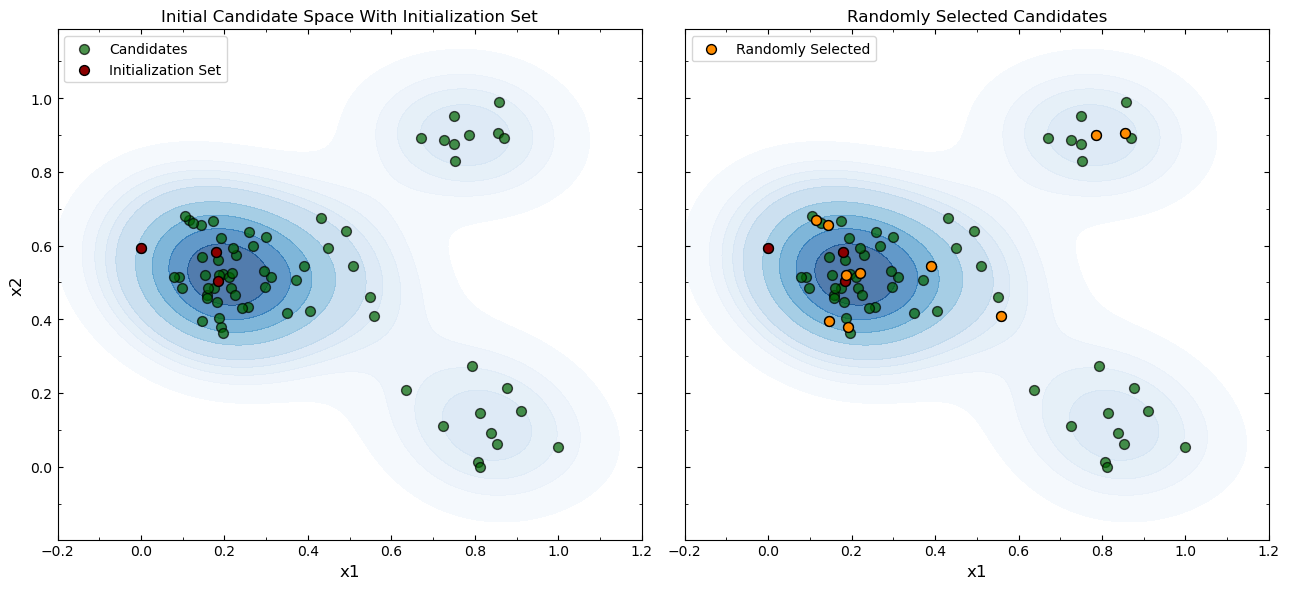

In [219]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13, 6),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True, alpha=0.7)
ax[0].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.7)
ax[0].scatter(xinit_rand[:3,0], xinit_rand[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initialization Set')
ax[0].set_title("Initial Candidate Space With Initialization Set", size=12)



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
ax[1].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=50, edgecolor='k', linewidth=1,alpha=0.7)
ax[1].scatter(xinit_rand[:3,0], xinit_rand[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1)
ax[1].scatter(xinit_rand[3:13,0], xinit_rand[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='Randomly Selected')

ax[1].set_title("Randomly Selected Candidates", size=12)

# ax[1].scatter(xinit_rand[:3,0], xinit_rand[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initialization Set')
# add text to initial points
# ax[1].text(xinit_rand[0,0], xinit_rand[0,1], 'init', fontsize=12, color='black')
# ax[1].text(xinit_rand[1,0], xinit_rand[1,1], 'init', fontsize=12, color='black')
# ax[1].text(xinit_rand[2,0], xinit_rand[2,1], 'init', fontsize=12, color='black', ha='left')

# ax[1].scatter(mcp[:,0], mcp[:,1], c='darkred', s=50, edgecolor='k', linewidth=1,alpha=0.1, label='MCP')
# ax[1].scatter(xtest[:,0], xtest[:,1], c='yellow', s=50, edgecolor='k', linewidth=1, label='Test Set')






for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=12)
    ax[i].set_ylabel("x2", size=12)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [146]:
selected_disagreements = []
max_disagreements = []

gp_commit_lst = []
candidate_disagreements = []    

committee = [
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

comit_pred_mae = []

commit_seeds = []
disagreement_scores_list = []
for i in tqdm(seeds):
    
    xcandidates_comit = xcandidates_original.clone()
    ycandidates_comit = ycandidates_original.clone()
    xinit_comit, yinit_comit, xcandidates_comit, ycandidates_comit = random_initial_data(xcandidates_comit, ycandidates_comit, 0.05, seed=i)
    gp_commit_lst = []
    
    yinit_comit = yinit_comit.unsqueeze(-1)
    ycandidates_comit = ycandidates_comit.unsqueeze(-1)
    
    gp = SingleTaskGP(xinit_comit, yinit_comit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    
    # gp_commit_lst.append(ypred)
    comitt_ymae = mean_absolute_error(ytest, ypred)
    gp_commit_lst.append(comitt_ymae)
    for inner_i in tqdm(range(len(xcandidates_comit))):
        if not len(xcandidates_comit):
            print('empty')
            break
        # print(f'this is {i}')
        # fit all 3 models 
        for model in committee:
            # print(model)
            model.fit(xinit_comit, yinit_comit)

    # Make predictions on the unlabeled data for each model in the committee
        predictions = np.array([model.predict(xcandidates_comit) for model in committee])

    
        disagreement_scores = np.var(predictions, axis=0)
        
        max_disagreements.append(np.max(disagreement_scores))
        
        N = 1  
        top_N_indices = np.argsort(disagreement_scores)[-N:]
        
        selected_disagreements.append(disagreement_scores[top_N_indices][0])

        disagreement_scores_list.append(disagreement_scores)
        candidate_disagreements.append(xcandidates_comit)
    # # The selected data points to query for labels
        X_to_query = xcandidates_comit[top_N_indices]
        
        ylabel = ycandidates_comit[top_N_indices]
        
        xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
        yinit_comit = torch.cat((yinit_comit, ylabel), 0)
        
        xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
        # print(f'len of x candidates: {len(xcandidates_comit)}')
        ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
        
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
            
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
    candidate_disagreements
    disagreement_scores_list
    commit_seeds.append(gp_commit_lst)
    
        

        


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


In [188]:
len(xinit_comit[3:8,0])

5

In [190]:
len(candidate_disagreements[5][:,0])

62

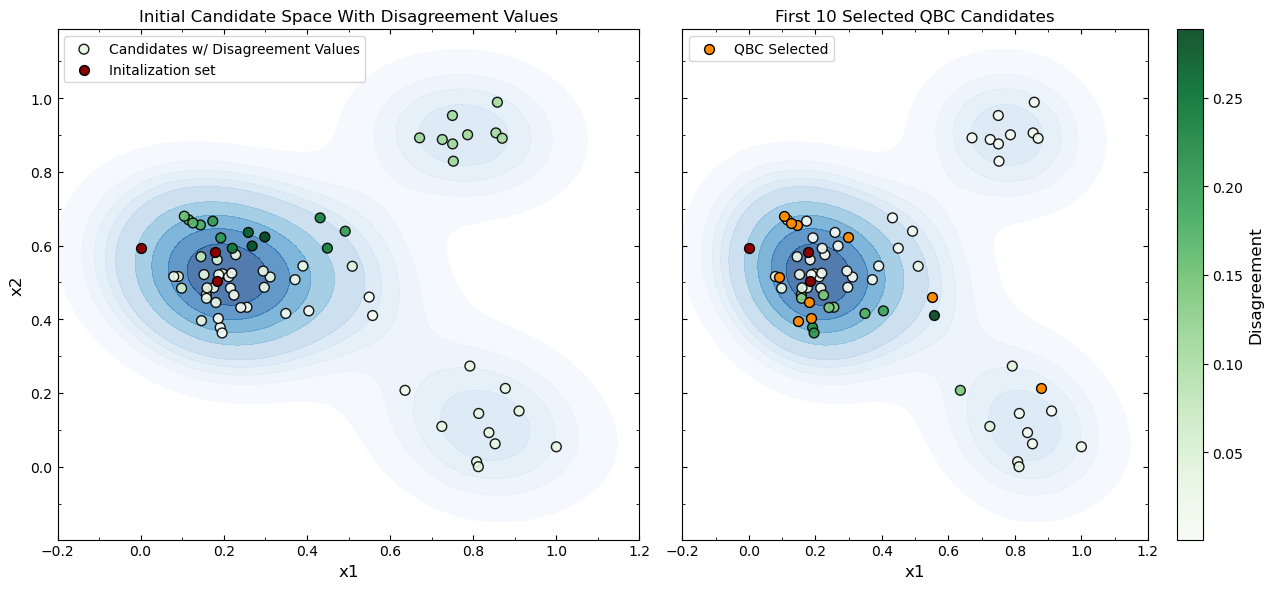

In [221]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13, 6),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True,alpha=0.7)
# ax[0].scatter(xcandidates[:,0], xcandidates[:,1], c='darkgreen', s=50, edgecolor='k',
# linewidth=1, label='candidates')
# ax[0].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initalization set')
ax[0].scatter(candidate_disagreements[0][:,0], candidate_disagreements[0][:,1], c=disagreement_scores_list[0], cmap="Greens",s=50, edgecolor='k', linewidth=1, label='Candidates w/ Disagreement Values',alpha=0.9)
ax[0].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initalization set')
ax[0].set_title("Initial Candidate Space With Disagreement Values", size=12)


#-----


sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)

cb = ax[1].scatter(candidate_disagreements[10][:,0], candidate_disagreements[10][:,1], c=disagreement_scores_list[10], cmap="Greens",s=50, edgecolor='k', linewidth=1,alpha=0.9)

cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("Disagreement", size=12)


ax[1].scatter(xinit_comit[:3,0], xinit_comit[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1)

ax[1].scatter(xinit_comit[3:13,0], xinit_comit[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='QBC Selected')
# ax[1].scatter(xinit_comit[3:9,0], xinit_comit[3:9,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='QBC Selected')
ax[1].set_title("First 10 Selected QBC Candidates", size=12)



for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, xcandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = xcandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=12)
    ax[i].set_ylabel("x2", size=12)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    # ax[i].set_title("Overlay Monte Carlo Points In Candidate Space", size=12)
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [194]:

# Setting random seeds
# torch.manual_seed(13)
# random.seed(1000)

# Initialize storage for results
uncr_xmax_candidates = []
uncr_pred_mae = []
uncr_pred_std = []
uncr_pred_mean = []
unc_rand_mae_seeds = []
uncr_pred_candidates = []
uncr_candidates = []
# Random seeds for repeatability


for i in seeds:
    # random.seed(seed)
    
    
    xcandidates_uncr = xcandidates_original.clone()
    ycandidates_uncr = ycandidates_original.clone()
    xinit_uncr, yinit_uncr, xcandidates_uncr, ycandidates_uncr = random_initial_data(xcandidates_uncr, ycandidates_uncr, 0.05, seed=i)
    
    yinit_uncr = yinit_uncr.unsqueeze(-1)
    ycandidates_uncr = ycandidates_uncr.unsqueeze(-1)
    
    # Initialize lists to store intermediate results
    uncr_xmax_candidates = []
    uncr_pred_mae = []
    uncr_pred_std = []
    uncr_pred_mean = []

    # Train the initial GP model on the initial training set
    gp = SingleTaskGP(xinit_uncr, yinit_uncr)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    # Predict on the test set initially
    uncr_ypred = gp(xtest)
    uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
    uncr_pred_mean.append(uncr_ypred_mean)
    
    # Calculate the initial mean absolute error (MAE) for the test set
    uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
    # print('Initial mean absolute error: ', uncr_ymae)
    uncr_pred_mae.append(uncr_ymae)
    
    # Calculate and store the initial standard deviation for the test set predictions
    uncr_ystd = gp(xtest).stddev.detach().numpy()
    uncr_pred_std.append(uncr_ystd)
    # print("Initial length of xinit", len(xinit_uncr))

    # Active learning loop (25 iterations)
    for inner_i in tqdm(range(len(xcandidates_uncr))):
        if not len(xcandidates_uncr):
            print('empty')
            break
        # Predict the uncertainty (posterior stddev) for all candidate points
        posterior_candidates = gp(xcandidates_uncr)
        uncertainties = posterior_candidates.stddev.detach().numpy()  # Extract the standard deviation (uncertainty)
        uncr_pred_candidates.append(uncertainties)
        uncr_candidates.append(xcandidates_uncr)

        # Find the index of the candidate point with the highest uncertainty
        max_uncertainty_idx = uncertainties.argmax()

        # Add the selected candidate (with the highest uncertainty) to the training set
        xinit_uncr = torch.cat((xinit_uncr, xcandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
        yinit_uncr = torch.cat((yinit_uncr, ycandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)

        # Print the length of the new training set
        # print('Length of new training set:', len(xinit_uncr))

        # Remove the selected candidate from the candidate set
        xcandidates_uncr = torch.cat((xcandidates_uncr[:max_uncertainty_idx], xcandidates_uncr[max_uncertainty_idx + 1:]))
        ycandidates_uncr = torch.cat((ycandidates_uncr[:max_uncertainty_idx], ycandidates_uncr[max_uncertainty_idx + 1:]))

        # Retrain the GP model on the updated training set
        gp = SingleTaskGP(xinit_uncr, yinit_uncr)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Predict the y values for the test set
        uncr_ypred = gp(xtest)
        uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
        uncr_pred_mean.append(uncr_ypred_mean)

        # Calculate the mean absolute error (MAE) for the test set
        uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
        # print(f'Iteration {i}: mean absolute error = {uncr_ymae}')
        uncr_pred_mae.append(uncr_ymae)

        # Calculate and store the standard deviation (uncertainty) of the test set predictions
        uncr_ystd = gp(xtest).stddev.detach().numpy()
        uncr_pred_std.append(uncr_ystd)
    uncr_pred_candidates
    uncr_candidates
    unc_rand_mae_seeds.append(uncr_pred_mae)
   

100%|██████████| 67/67 [00:02<00:00, 26.17it/s]


In [199]:
len(uncr_pred_candidates[1])

66

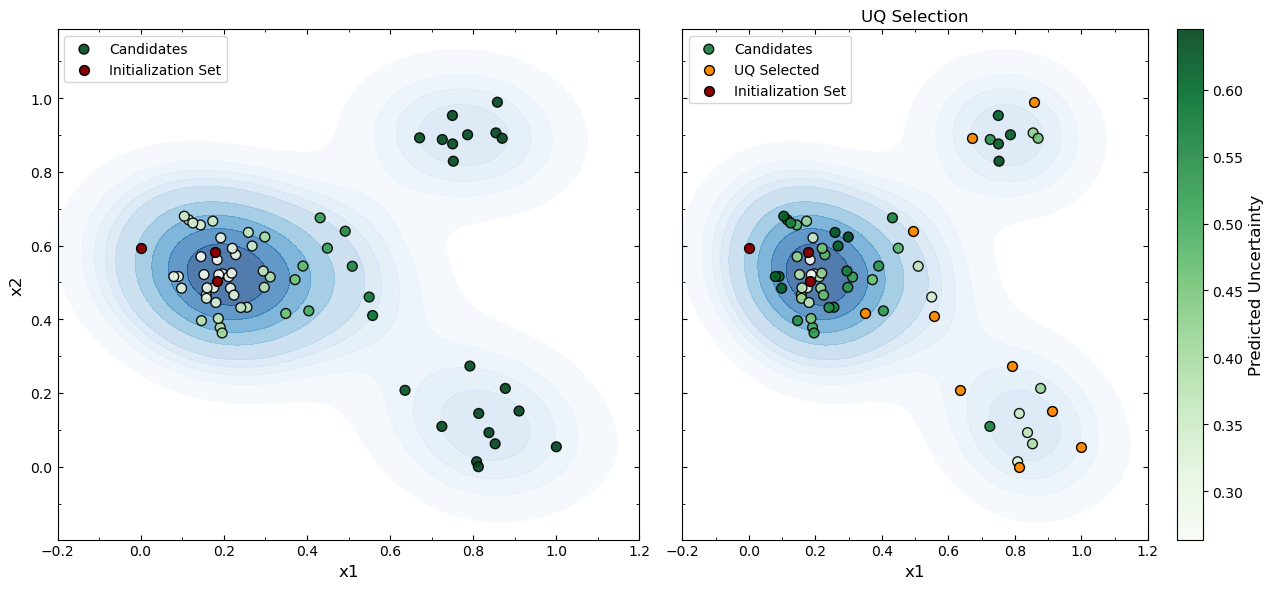

In [222]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(13, 6),sharex=True,sharey=True)

xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[0],legend=True, alpha=0.7)
cb = ax[0].scatter(uncr_candidates[0][:,0], uncr_candidates[0][:,1], c=uncr_pred_candidates[0], cmap="Greens",s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.9)

ax[0].scatter(xinit_uncr[:3,0], xinit_uncr[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initialization Set')



sns.kdeplot(x=xcandidates[:,0], y=xcandidates[:,1], cmap='Blues', fill=True, ax=ax[1],legend=True,alpha=0.7)
cb = ax[1].scatter(uncr_candidates[10][:,0], uncr_candidates[10][:,1], c=uncr_pred_candidates[10], cmap="Greens",s=50, edgecolor='k', linewidth=1, label='Candidates',alpha=0.9)

cbar = fig.colorbar(cb, ax=ax[1])
cbar.set_label("Predicted Uncertainty", size=12)

ax[1].scatter(xinit_uncr[3:13,0], xinit_uncr[3:13,1], c='darkorange', s=50, edgecolor='k', linewidth=1, label='UQ Selected')
ax[1].scatter(xinit_uncr[:3,0], xinit_uncr[:3,1], c='darkred', s=50, edgecolor='k', linewidth=1, label='Initialization Set')
ax[1].set_title("UQ Selection", size=12)







for i in range(len(ax)):
    xcandidates_min1, xcandidates_max1 = xcandidates[:,0].min(), xcandidates[:,0].max()
    xcandidates_min2, ycandidates_max2 = xcandidates[:,1].min(), xcandidates[:,1].max()

    padding_factor = 0.2
    xcandidates_range1 = xcandidates_max1 - xcandidates_min1
    xcandidates_range2 = ycandidates_max2 - xcandidates_min2

    ax[i].set_xlim(xcandidates_min1 - padding_factor * xcandidates_range1, xcandidates_max1 + padding_factor * xcandidates_range1)
    ax[i].set_ylim(xcandidates_min2 - padding_factor * xcandidates_range2, ycandidates_max2 + padding_factor * xcandidates_range2)
    ax[i].set_xlabel("x1", size=12)
    ax[i].set_ylabel("x2", size=12)
    ax[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax[i].minorticks_on()
    ax[i].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()